**Import Libraries**

In [1]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

# MoCo v2 library
from lightly.transforms.moco_transform import MoCoV2Transform
from lightly.models.modules import MoCoProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NTXentLoss
from lightly.utils.scheduler import cosine_schedule

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [2]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Parameters MoCo pre-training
LEARNING_RATE_MoCo = 0.06
EPOCHS_MoCo = 100
BATCH_SIZE_MoCo = 128

# Parameters training
LEARNING_RATE = 0.001
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 3
EPOCHS_FINE_TUNING = 100
BATCH_SIZE = 32

# Parameters early stopping
EARLY_STOPPING_PATIENCE = 10

# Parameters learning rate scheduler
LEARNING_RATE_SCHEDULER_PATIENCE = 5
LEARNING_RATE_SCHEDULER_MODE = 'min'
LEARNING_RATE_SCHEDULER_FACTOR = 0.1

# Other parameters
SEED = 42
NUM_WORKERS = 16

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [3]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [4]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [5]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [6]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 78614
Validation size: 11212
Test size: 22294


**Define Dataset for Chest X-ray images**

In [7]:
class ChestXrayDataset(Dataset):
    """
    Create dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get image and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation on image
        image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [8]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [9]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: MoCo Pre-training**

**Define the MoCo transformations**

In [11]:
moco_transform = transforms.Compose([
    
    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Apply random cropping and resize the image to 224x224
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Define the BYOL model**

In [12]:
class MoCo(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
        self.projection_head = MoCoProjectionHead(1000, 1024, 256)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        query = self.backbone(x).flatten(start_dim=1)
        query = self.projection_head(query)
        return query

    def forward_momentum(self, x):
        key = self.backbone_momentum(x).flatten(start_dim=1)
        key = self.projection_head_momentum(key).detach()
        return key

# Initalize MoCo model
moco_model = MoCo().to(device)

**Create MoCo Dataset**

In [13]:
class MoCoDataset(torch.utils.data.Dataset):
    """
    Custom Dataset for MoCo.
    Returns two augmented versions of each image.
    """
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)

        # Apply the BYOL transform to generate two augmented views
        view1, view2 = self.transform(image), self.transform(image)

        return view1, view2

# Create train and test dataset
moco_train_dataset = MoCoDataset(train_df, transform=moco_transform)
moco_val_dataset = MoCoDataset(val_df, transform=moco_transform)

**Initialize BYOL DataLoader**

In [14]:
moco_train_loader = DataLoader(
    moco_train_dataset,
    batch_size=BATCH_SIZE_MoCo,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

moco_val_loader = DataLoader(
    moco_val_dataset,
    batch_size=BATCH_SIZE_MoCo,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=False
)

**Initialize Optimizer and Loss for BYOL**

In [15]:
criterion = NTXentLoss(memory_bank_size=(4096, 256))
optimizer_moco = torch.optim.SGD(moco_model.parameters(), lr=0.06)

**Train MoCo Model**

In [16]:
def train_model(moco_model, moco_train_loader, moco_val_loader, criterion, optimizer_moco, patience, epochs=10):

    # List to store byol loss
    moco_train_losses = []
    moco_val_losses = []

    # Early stopping parameters
    best_loss = 1000
    epochs_without_improvement = 0

    for epoch in range(epochs):

        train_loss = 0.0
        progress_bar = tqdm(moco_train_loader, desc=f"MoCo Epoch {epoch+1}/{epochs}")
        momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)

        for batch in progress_bar:
            x_query, x_key = batch
            update_momentum(moco_model.backbone, moco_model.backbone_momentum, m=momentum_val)
            update_momentum(
                moco_model.projection_head, moco_model.projection_head_momentum, m=momentum_val
            )

            x_query = x_query.to(device)
            x_key = x_key.to(device)

            # Forward pass
            query = moco_model(x_query)
            key = moco_model.forward_momentum(x_key)

            # Compute loss
            loss = criterion(query, key)

            # Backward pass and optimization
            loss.backward()
            optimizer_moco.step()
            optimizer_moco.zero_grad()

            train_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})

        train_loss = train_loss / len(moco_train_loader)
        moco_train_losses.append(train_loss)

        # Validation loop
        moco_model.eval()
        val_loss = 0
        progress_bar = tqdm(moco_val_loader, desc=f"BYOL Epoch {epoch+1}/{epochs}")

        with torch.no_grad():
            for batch in progress_bar:
                x_query, x_key = batch

                x_query = x_query.to(device)
                x_key = x_key.to(device)

                # Forward pass
                query = moco_model(x_query)
                key = moco_model.forward_momentum(x_key)

                # Compute loss
                loss = criterion(query, key)
                
                val_loss  += loss.item()
                progress_bar.set_postfix({"Loss": loss.item()})

        val_loss = val_loss / len(moco_val_loader)
        moco_val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if best_loss > val_loss:
            best_loss = val_loss
            epochs_without_improvement = 0
            torch.save(moco_model.state_dict(), 'best_model_2.pt')
            print(f"New best model saved with Loss: {val_loss:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience :
                print(f"Early stopping. No improvement for {patience } epochs")
                break

    # Load the best model
    moco_model.load_state_dict(torch.load('best_model_2.pt', weights_only=True))

    return moco_train_losses, moco_val_losses


# Train the model
moco_train_losses, moco_val_losses = train_model(moco_model, moco_train_loader, moco_val_loader, criterion, optimizer_moco, EARLY_STOPPING_PATIENCE, EPOCHS_MoCo)

BYOL Epoch 1/100: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s, Loss=6.67]


Epoch 1/100 | Training Loss: 7.1121 | Validation Loss: 6.7776
New best model saved with Loss: 6.7776


BYOL Epoch 2/100: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s, Loss=6.68]


Epoch 2/100 | Training Loss: 7.1013 | Validation Loss: 6.7960


BYOL Epoch 3/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=6.61]


Epoch 3/100 | Training Loss: 6.7299 | Validation Loss: 6.7302
New best model saved with Loss: 6.7302


BYOL Epoch 4/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=6.59]


Epoch 4/100 | Training Loss: 6.6723 | Validation Loss: 6.6516
New best model saved with Loss: 6.6516


BYOL Epoch 5/100: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s, Loss=6.57]


Epoch 5/100 | Training Loss: 6.6467 | Validation Loss: 6.6316
New best model saved with Loss: 6.6316


BYOL Epoch 6/100: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s, Loss=6.56]


Epoch 6/100 | Training Loss: 6.6336 | Validation Loss: 6.6122
New best model saved with Loss: 6.6122


BYOL Epoch 7/100: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s, Loss=6.57]


Epoch 7/100 | Training Loss: 6.6231 | Validation Loss: 6.6011
New best model saved with Loss: 6.6011


BYOL Epoch 8/100: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s, Loss=6.55]


Epoch 8/100 | Training Loss: 6.6145 | Validation Loss: 6.6064


BYOL Epoch 9/100: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s, Loss=6.55]


Epoch 9/100 | Training Loss: 6.6120 | Validation Loss: 6.5935
New best model saved with Loss: 6.5935


BYOL Epoch 10/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=6.58]


Epoch 10/100 | Training Loss: 6.6045 | Validation Loss: 6.6016


BYOL Epoch 11/100: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s, Loss=6.55]


Epoch 11/100 | Training Loss: 6.5984 | Validation Loss: 6.6306


BYOL Epoch 12/100: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s, Loss=6.55]


Epoch 12/100 | Training Loss: 6.5952 | Validation Loss: 6.5902
New best model saved with Loss: 6.5902


BYOL Epoch 13/100: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s, Loss=6.51]


Epoch 13/100 | Training Loss: 6.5907 | Validation Loss: 6.5814
New best model saved with Loss: 6.5814


BYOL Epoch 14/100: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s, Loss=6.55]


Epoch 14/100 | Training Loss: 6.5889 | Validation Loss: 6.5807
New best model saved with Loss: 6.5807


BYOL Epoch 15/100: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s, Loss=6.55]


Epoch 15/100 | Training Loss: 6.5853 | Validation Loss: 6.5951


BYOL Epoch 16/100: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s, Loss=6.56]


Epoch 16/100 | Training Loss: 6.5831 | Validation Loss: 6.5786
New best model saved with Loss: 6.5786


BYOL Epoch 17/100: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s, Loss=6.53]


Epoch 17/100 | Training Loss: 6.5834 | Validation Loss: 6.5854


BYOL Epoch 18/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=6.56]


Epoch 18/100 | Training Loss: 6.5838 | Validation Loss: 6.5922


BYOL Epoch 19/100: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s, Loss=6.54]


Epoch 19/100 | Training Loss: 6.5825 | Validation Loss: 6.5933


BYOL Epoch 20/100: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s, Loss=6.54]


Epoch 20/100 | Training Loss: 6.5846 | Validation Loss: 6.5997


BYOL Epoch 21/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=6.55]


Epoch 21/100 | Training Loss: 6.5809 | Validation Loss: 6.5763
New best model saved with Loss: 6.5763


BYOL Epoch 22/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=6.55]


Epoch 22/100 | Training Loss: 6.5801 | Validation Loss: 6.5820


BYOL Epoch 23/100: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s, Loss=6.51]


Epoch 23/100 | Training Loss: 6.5797 | Validation Loss: 6.5766


BYOL Epoch 24/100: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s, Loss=6.57]


Epoch 24/100 | Training Loss: 6.5789 | Validation Loss: 6.6099


BYOL Epoch 25/100: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s, Loss=6.55]


Epoch 25/100 | Training Loss: 6.5773 | Validation Loss: 6.5692
New best model saved with Loss: 6.5692


BYOL Epoch 26/100: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s, Loss=6.51]


Epoch 26/100 | Training Loss: 6.5761 | Validation Loss: 6.5734


BYOL Epoch 27/100: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s, Loss=6.51]


Epoch 27/100 | Training Loss: 6.5754 | Validation Loss: 6.5659
New best model saved with Loss: 6.5659


BYOL Epoch 28/100: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s, Loss=6.53]


Epoch 28/100 | Training Loss: 6.5746 | Validation Loss: 6.5708


BYOL Epoch 29/100: 100%|██████████| 88/88 [01:02<00:00,  1.41it/s, Loss=6.53]


Epoch 29/100 | Training Loss: 6.5748 | Validation Loss: 6.5665


BYOL Epoch 30/100: 100%|██████████| 88/88 [01:09<00:00,  1.26it/s, Loss=6.54]


Epoch 30/100 | Training Loss: 6.5735 | Validation Loss: 6.5798


BYOL Epoch 31/100: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s, Loss=6.56]


Epoch 31/100 | Training Loss: 6.5732 | Validation Loss: 6.5828


BYOL Epoch 32/100: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s, Loss=6.52]


Epoch 32/100 | Training Loss: 6.5732 | Validation Loss: 6.5916


BYOL Epoch 33/100: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s, Loss=6.5] 


Epoch 33/100 | Training Loss: 6.5736 | Validation Loss: 6.5750


BYOL Epoch 34/100: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s, Loss=6.54]


Epoch 34/100 | Training Loss: 6.5735 | Validation Loss: 6.5739


BYOL Epoch 35/100: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s, Loss=6.55]


Epoch 35/100 | Training Loss: 6.5747 | Validation Loss: 6.5683


BYOL Epoch 36/100: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s, Loss=6.5] 


Epoch 36/100 | Training Loss: 6.5712 | Validation Loss: 6.5676


BYOL Epoch 37/100: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s, Loss=6.52]


Epoch 37/100 | Training Loss: 6.5715 | Validation Loss: 6.5841
Early stopping. No improvement for 10 epochs


# **Step 4: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [17]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, backbone, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Swin Transformer model
        self.base_model = backbone.backbone


        # Replace the classification head to match the number of disease labels
        self.base_model.classifier = nn.Linear(self.base_model.classifier.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = MultiLabelClassifier(moco_model)
model.to(device)

MultiLabelClassifier(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-

**Use Multiple GPUs**

In [18]:
model = nn.DataParallel(model)

# **Step 5: Train the Model**

**Step 1: Train Classification Head Only**

In [19]:
# Freeze the backbone parameters
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

In [20]:
# Initialize loss function
criterion = nn.BCEWithLogitsLoss()

# Initialize optimizer
optimizer_head = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model_2.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience} epochs")
                break
                
    # Load the best model
    model.load_state_dict(torch.load('best_model_2.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

# Train the model
train_losses_1, val_losses_1, val_aucs_1 = train_model(model, train_loader, val_loader, criterion, optimizer_head, EARLY_STOPPING_PATIENCE, EPOCHS)

Epoch 1/3: 100%|██████████| 351/351 [00:19<00:00, 17.71it/s, Loss=0.153] 


Epoch 1/3 | Training Loss: 0.1734 | Validation Loss: 0.1696 | Mean Validation AUC: 0.7273
New best model saved with Mean Validation AUC: 0.7273


Epoch 2/3: 100%|██████████| 351/351 [00:19<00:00, 17.75it/s, Loss=0.161] 


Epoch 2/3 | Training Loss: 0.1699 | Validation Loss: 0.1683 | Mean Validation AUC: 0.7366
New best model saved with Mean Validation AUC: 0.7366


Epoch 3/3: 100%|██████████| 351/351 [00:19<00:00, 17.66it/s, Loss=0.158] 


Epoch 3/3 | Training Loss: 0.1688 | Validation Loss: 0.1669 | Mean Validation AUC: 0.7419
New best model saved with Mean Validation AUC: 0.7419


**Step 2: Fine Tune Entire Network**

In [22]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

In [23]:
# Initialize optimizer
optimizer_full = optim.Adam(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model_2.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience:.4f} epochs")
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_2.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses_2, val_losses_2, val_aucs_2 = train_model(model, train_loader, val_loader, criterion, optimizer_full, EARLY_STOPPING_PATIENCE, EPOCHS_FINE_TUNING)

Epoch 1/100: 100%|██████████| 351/351 [00:19<00:00, 17.76it/s, Loss=0.123] 


Epoch 1/100 | Training Loss: 0.1574 | Validation Loss: 0.1497 | Mean Validation AUC: 0.8133
New best model saved with Mean Validation AUC: 0.8133


Epoch 2/100: 100%|██████████| 351/351 [00:19<00:00, 18.09it/s, Loss=0.122] 


Epoch 2/100 | Training Loss: 0.1496 | Validation Loss: 0.1472 | Mean Validation AUC: 0.8261
New best model saved with Mean Validation AUC: 0.8261


Epoch 3/100: 100%|██████████| 351/351 [00:19<00:00, 17.84it/s, Loss=0.112] 


Epoch 3/100 | Training Loss: 0.1456 | Validation Loss: 0.1465 | Mean Validation AUC: 0.8323
New best model saved with Mean Validation AUC: 0.8323


Epoch 4/100: 100%|██████████| 351/351 [00:19<00:00, 17.75it/s, Loss=0.116] 


Epoch 4/100 | Training Loss: 0.1423 | Validation Loss: 0.1460 | Mean Validation AUC: 0.8334
New best model saved with Mean Validation AUC: 0.8334


Epoch 5/100: 100%|██████████| 351/351 [00:19<00:00, 17.65it/s, Loss=0.11]  


Epoch 5/100 | Training Loss: 0.1394 | Validation Loss: 0.1470 | Mean Validation AUC: 0.8340
New best model saved with Mean Validation AUC: 0.8340


Epoch 6/100: 100%|██████████| 351/351 [00:19<00:00, 18.11it/s, Loss=0.122] 


Epoch 6/100 | Training Loss: 0.1366 | Validation Loss: 0.1478 | Mean Validation AUC: 0.8267


Epoch 7/100: 100%|██████████| 351/351 [00:19<00:00, 18.00it/s, Loss=0.105] 


Epoch 7/100 | Training Loss: 0.1333 | Validation Loss: 0.1490 | Mean Validation AUC: 0.8254


Epoch 8/100: 100%|██████████| 351/351 [00:19<00:00, 17.94it/s, Loss=0.104] 


Epoch 8/100 | Training Loss: 0.1298 | Validation Loss: 0.1473 | Mean Validation AUC: 0.8332


Epoch 9/100: 100%|██████████| 351/351 [00:19<00:00, 17.89it/s, Loss=0.117] 


Epoch 9/100 | Training Loss: 0.1259 | Validation Loss: 0.1503 | Mean Validation AUC: 0.8277


Epoch 10/100: 100%|██████████| 351/351 [00:19<00:00, 17.68it/s, Loss=0.112] 


Epoch 10/100 | Training Loss: 0.1219 | Validation Loss: 0.1548 | Mean Validation AUC: 0.8234


Epoch 11/100: 100%|██████████| 351/351 [00:19<00:00, 17.69it/s, Loss=0.138] 


Epoch 11/100 | Training Loss: 0.1172 | Validation Loss: 0.1575 | Mean Validation AUC: 0.8159


Epoch 12/100: 100%|██████████| 351/351 [00:19<00:00, 17.90it/s, Loss=0.123] 


Epoch 12/100 | Training Loss: 0.1122 | Validation Loss: 0.1611 | Mean Validation AUC: 0.8160


Epoch 13/100: 100%|██████████| 351/351 [00:19<00:00, 17.87it/s, Loss=0.1]   


Epoch 13/100 | Training Loss: 0.1072 | Validation Loss: 0.1690 | Mean Validation AUC: 0.8114


Epoch 14/100: 100%|██████████| 351/351 [00:19<00:00, 17.61it/s, Loss=0.129] 


Epoch 14/100 | Training Loss: 0.1017 | Validation Loss: 0.1730 | Mean Validation AUC: 0.8003


Epoch 15/100: 100%|██████████| 351/351 [00:19<00:00, 17.76it/s, Loss=0.118] 


Epoch 15/100 | Training Loss: 0.0959 | Validation Loss: 0.1765 | Mean Validation AUC: 0.7948
Early stopping. No improvement for 10.0000 epochs


# **Step 6: Evaluate the Model**

**Test-time Augmentations**

In [25]:
tta_transforms = [
    lambda img: img,
    lambda img: transforms.RandomHorizontalFlip(p=1.0)(img),
    lambda img: transforms.RandomRotation(10)(img)
]

**Evaluate the Model**

In [26]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Apply each TTA transformation and predict
            for tta in tta_transforms:
                augmented_inputs = tta(inputs)
                outputs = model(augmented_inputs)
                preds = torch.sigmoid(outputs)
                tta_preds.append(preds)

            # Average the predictions across TTA transforms
            avg_preds = torch.stack(tta_preds).mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 697/697 [00:56<00:00, 12.41it/s]


**Compute Metrics for Each Label**

In [27]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
f1_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate f1 score
    f1 = f1_score(labels[:, i], binary_preds, average='macro')

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    f1_per_label[label] = f1
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

# Print dataframe with metrics
metrics_df

,Accuracy,F1 Score,ROC AUC
Atelectasis,0.903427,0.563628,0.808562
Consolidation,0.957343,0.489103,0.817543
Infiltration,0.813627,0.507098,0.704616
Pneumothorax,0.952409,0.627057,0.872053
Edema,0.979232,0.515455,0.886360
Emphysema,0.976316,0.595198,0.906820
Fibrosis,0.983404,0.521455,0.799535
Effusion,0.898448,0.695810,0.881436
Pneumonia,0.986813,0.496681,0.746748
Pleural_Thickening,0.969543,0.500949,0.801212


**Plot ROC curves for each label**

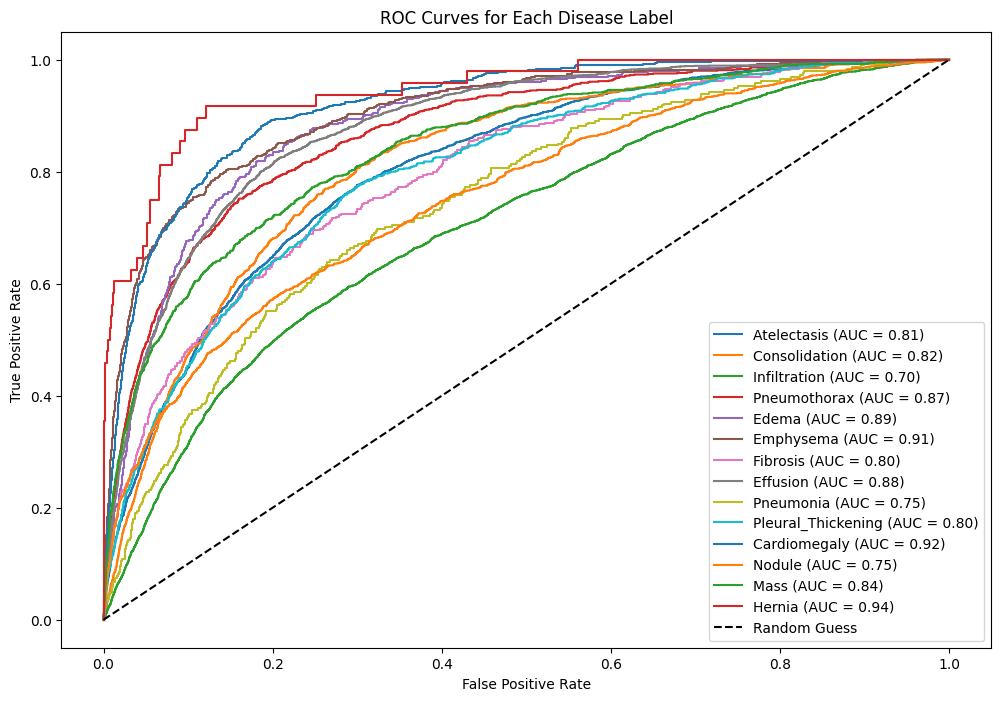

In [28]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

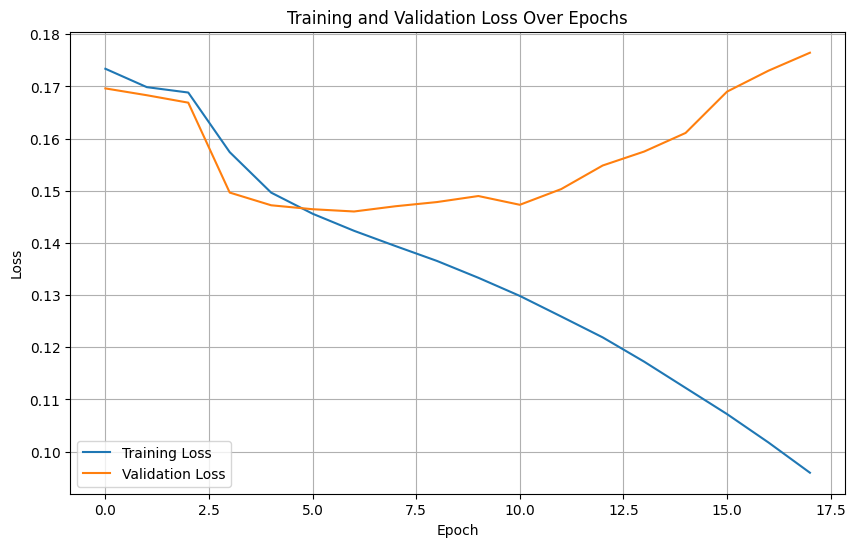

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_1 + train_losses_2, label='Training Loss')
plt.plot(val_losses_1 + val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Training and Validation Loss only Fine-tuning**

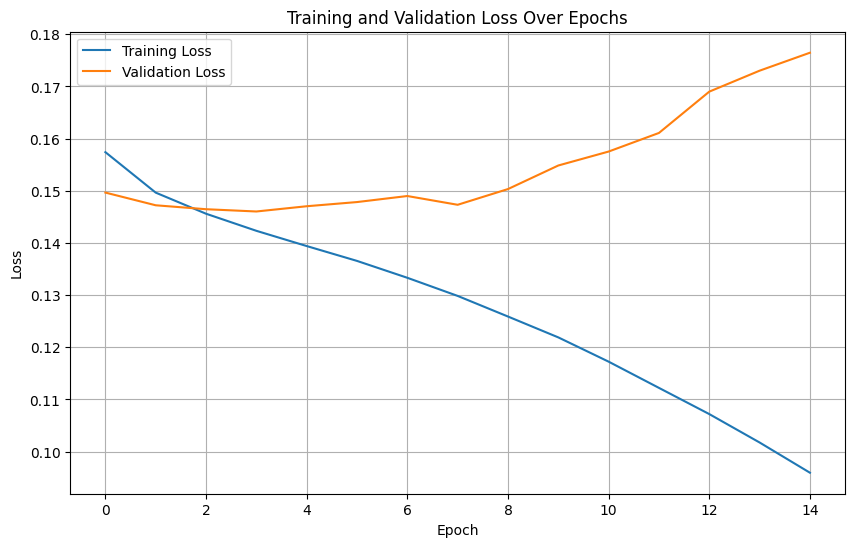

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label='Training Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

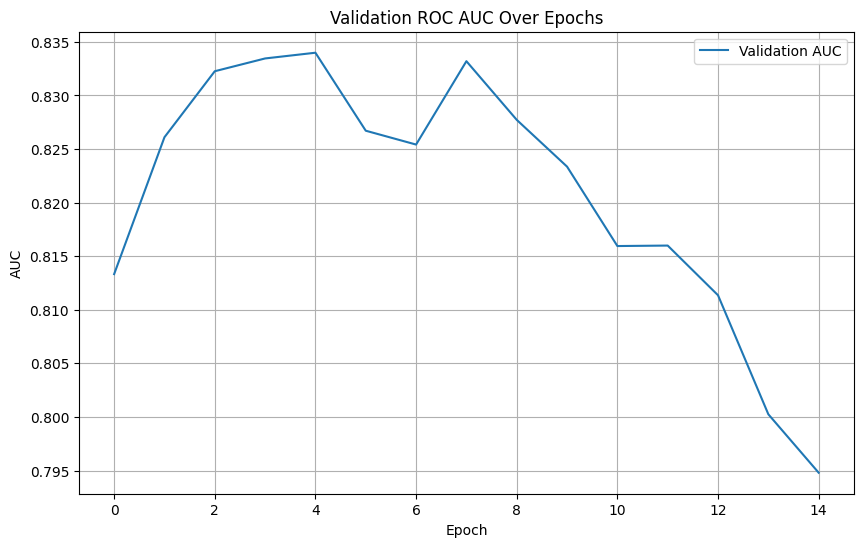

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC only Fine-tuning**

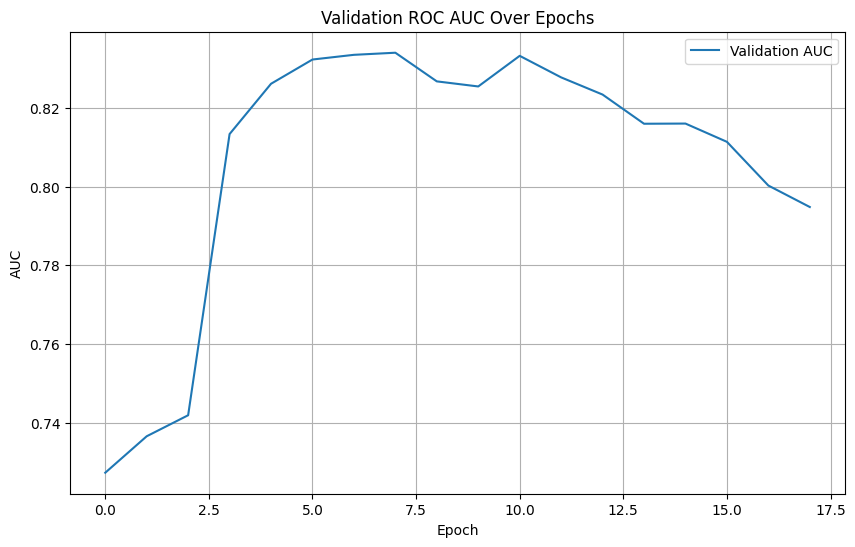

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_1 + val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot MoCo Loss**

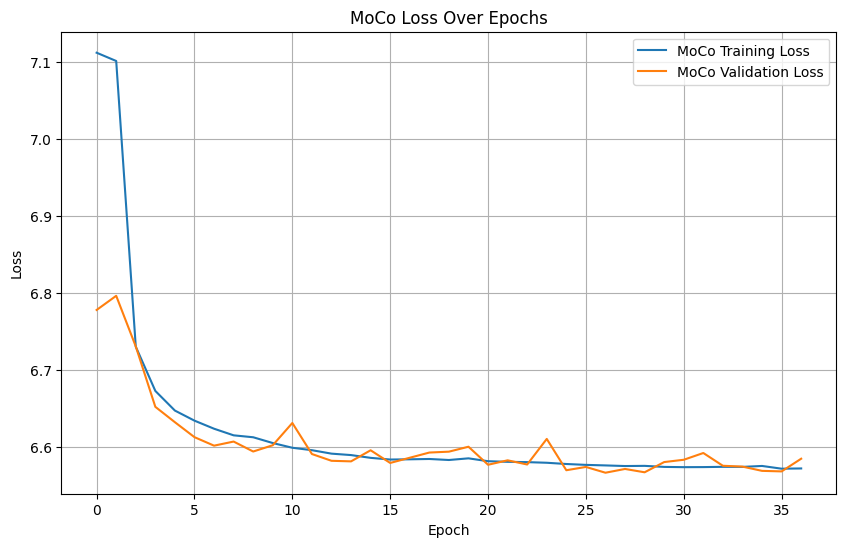

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(moco_train_losses, label='MoCo Training Loss')
plt.plot(moco_val_losses, label='MoCo Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MoCo Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()